# Processing Sequence using RNN and CNN

In [2]:
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("Tensorflow version: ", tf.__version__)

def cls():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

Tensorflow version:  2.6.0


In [ ]:
# Lets download Ridership data
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)


In [3]:
# Do some preprocessing
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)
df.head()

day_type     bus    rail
date                               
2001-01-01        U  297192  126455
2001-01-02        W  780827  501952
2001-01-03        W  824923  536432
2001-01-04        W  870021  550011
2001-01-05        W  890426  557917

In [4]:
df.day_type.value_counts()

W    5336
U    1216
A    1087
Name: day_type, dtype: int64

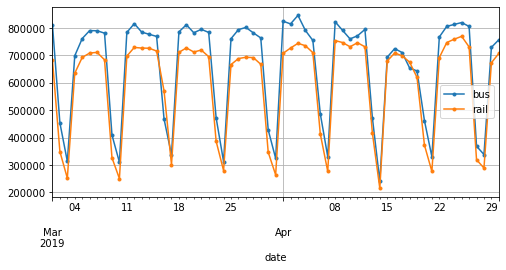

In [5]:
# Lets plot some month of 2019
df["2019-03":"2019-04"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

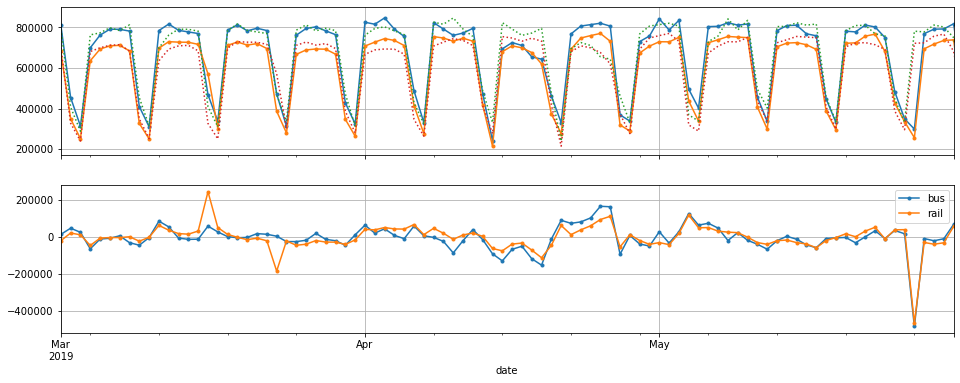

In [6]:
# To remove weekly trend
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"] # Difference of current value and its next 7th value

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16, 6))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # 7 day lagged value

diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [8]:
# MAPE of two series
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

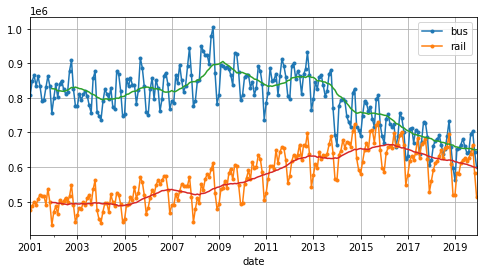

In [9]:
#Lets look at the yearly seasonality and the long term trends.

period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()
# Green and Red is normalized or 12 month moving average value

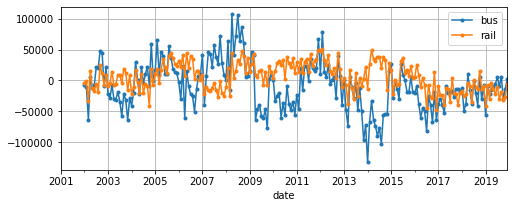

In [10]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-01    427758.626282
Freq: D, dtype: float64

In [12]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [13]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [14]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae  

32040.720093289623

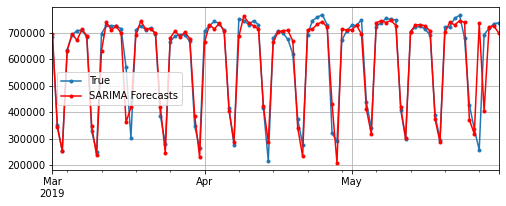

In [15]:
# Display the SARIMA forecast
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

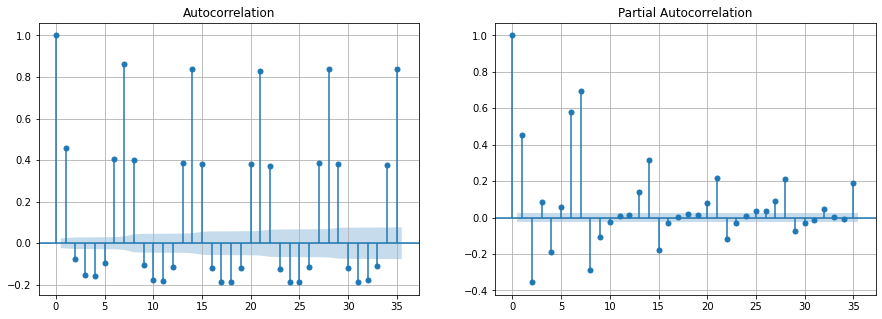

In [16]:
# Plotting the Autocorrelation Function (ACF) and the
# Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

# B. Sequence-to-Vector Modelling 

In [17]:
########################################
# Create empty series using tensorflow #
########################################

# Here we first store the series value in array or list
my_series = [0, 1, 2, 3, 4, 5, 6]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2,
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[2, 3, 4],
         [3, 4, 5]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([5, 6])>)]

In [18]:
# Same series using tf.data module
for window_dataset in tf.data.Dataset.range(7).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 6 
4 5 6 
5 6 
6 


In [19]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [33]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True) # This window function convert data into window chunk in Dataset format not Tensor
    return dataset.flat_map(lambda window_ds: window_ds.batch(length)) # This function will convert tf.Dataset into tf.Tensor that our model need.
dataset = to_windows(tf.data.Dataset.range(7), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1])) # This function will convert tf.Tensor into window chunks that we did earlier
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[2, 3, 4],
         [3, 4, 5]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([5, 6], dtype=int64)>)]

In [34]:
dataset = tf.data.Dataset.range(7)
dataset = dataset.window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(4))
#dataset = dataset.shuffle(20)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(2).prefetch(1)
list(dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[2, 3, 4],
         [3, 4, 5]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([5, 6], dtype=int64)>)]

In [35]:
# You can combine above operation into below funtion as well
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [36]:
##################
# Data splitting #
##################

# data normalizing
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [37]:
rail_train.head() # univarient series,  3 years of data single value for 1 day ==> 365*3 +1 = 1096 total values

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
Name: rail, dtype: float64

In [38]:
seq_length = 5
batch_size = 12
cls()
# Sequence to vector kind of data formatting
# 56 sequence of values give 57th prediction.
# It drop the last sequence /drop_remainder=True
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_size,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=batch_size
)

In [39]:
list(train_ds)[0] # 12*5 => 12 batch 5 cotinuous sequence number

(<tf.Tensor: shape=(12, 5), dtype=float64, numpy=
 array([[0.430711, 0.704247, 0.735234, 0.732813, 0.74543 ],
        [0.737535, 0.726872, 0.720483, 0.405211, 0.296805],
        [0.721661, 0.729861, 0.75728 , 0.861954, 0.831628],
        [0.514174, 0.58774 , 0.591081, 0.572525, 0.292077],
        [0.766072, 0.750353, 0.758014, 0.767974, 0.406616],
        [0.748703, 0.75806 , 0.732007, 0.404779, 0.304418],
        [0.477767, 0.351048, 0.716772, 0.700422, 0.734845],
        [0.344784, 0.336441, 0.722529, 0.745189, 0.771134],
        [0.426851, 0.327855, 0.74655 , 0.77778 , 0.752143],
        [0.336109, 0.740387, 0.763274, 0.779477, 0.785637],
        [0.891357, 1.146516, 0.531687, 0.380648, 0.809878],
        [0.323263, 0.245376, 0.419604, 0.710906, 0.71368 ]])>,
 <tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([0.756699, 0.702129, 0.521622, 0.226604, 0.345432, 0.690624,
        0.751673, 0.796256, 0.744199, 0.760661, 0.79187 , 0.720369])>)

In [40]:
rail_train.head(12)

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
2016-01-06    0.733167
2016-01-07    0.736809
2016-01-08    0.732495
2016-01-09    0.391597
2016-01-10    0.263073
2016-01-11    0.694734
2016-01-12    0.705694
Name: rail, dtype: float64

### 1. Simple Linear model

In [41]:
###########################################
# Lets first build a simple Linear model. #
###########################################
# Suppose these 5 are not sequence they are features: we try to fit a linear combination of these 5 features
cls()
model = tf.keras.Sequential([
                tf.keras.layers.Dense(1, input_shape=[seq_length])]) # seq_length = 5 

model.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=4) # (12,5) (12,)
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

Epoch 1/4
91/91 [==============================] - 1s 3ms/step - loss: 0.6543 - mae: 1.1400 - val_loss: 0.4228 - val_mae: 0.8729
Epoch 2/4
91/91 [==============================] - 0s 2ms/step - loss: 0.3549 - mae: 0.7873 - val_loss: 0.2119 - val_mae: 0.5699
Epoch 3/4
91/91 [==============================] - 0s 1ms/step - loss: 0.1718 - mae: 0.5131 - val_loss: 0.1088 - val_mae: 0.4039
Epoch 4/4
13/13 [==============================] - 0s 767us/step - loss: 0.0702 - mae: 0.3240


323983.8182926178

In [42]:
weights, bias = model.get_weights()
len(weights), len(bias) # Total 5 parameters: 4 of feature neuron + 1 bias

(5, 1)

### 2. Simple RNN model

In [376]:
###########################################
# Building the same model using RNN layer #
###########################################

#defines a utility function we'll reuse several time
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=4, metrics=["mae"]):
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=metrics)
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs)
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae

cls()
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), # Axis -1 insert 1 at last position [12,5]--> [12,5,1]
    tf.keras.layers.SimpleRNN(1) # Default activation function is tanh so output would be in range -1 to 1
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.get_weights() # Wxx, Wxh, Wb

[array([[0.5700599]], dtype=float32),
 array([[1.]], dtype=float32),
 array([0.], dtype=float32)]

In [45]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/4
91/91 [==============================] - 1s 3ms/step - loss: 0.0192 - mae: 0.1597 - val_loss: 0.0210 - val_mae: 0.1547
Epoch 2/4
91/91 [==============================] - 0s 2ms/step - loss: 0.0166 - mae: 0.1573 - val_loss: 0.0207 - val_mae: 0.1483
Epoch 3/4
91/91 [==============================] - 0s 2ms/step - loss: 0.0161 - mae: 0.1551 - val_loss: 0.0189 - val_mae: 0.1524
Epoch 4/4
13/13 [==============================] - 0s 1ms/step - loss: 0.0187 - mae: 0.1503


0.15025538206100464

In [46]:
model.get_weights() # Wxx, Wxh, Wb

[array([[0.4148249]], dtype=float32),
 array([[0.5648627]], dtype=float32),
 array([0.15581825], dtype=float32)]

### 3. Deep RNN

In [47]:
train_ds2 = train_ds.map(lambda x,y: (tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1))) # [12,5,1]
valid_ds2 = valid_ds.map(lambda x,y: (tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1))) # [12,5,1]
x_test, y_test = list(valid_ds2.take(1))[0][0], list(valid_ds2.take(1))[0][1]
list(train_ds2.take(1))[0][0].shape

TensorShape([12, 5, 1])

In [48]:
###################################################################################
# input_feature*neuron + neuron*neuron(self weight and output weight) + bias term #
###################################################################################
cls()
# We don't need to pass the sequence length
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(5, return_sequences=True),
    tf.keras.layers.SimpleRNN(1) # RNN expect input in 3D so this layer expect input [None, None, 50]
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 10)          120       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 5)           80        
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1)                 7         
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [49]:
fit_and_evaluate(model, train_ds2, valid_ds2, learning_rate=0.02)

Epoch 1/4
91/91 [==============================] - 2s 6ms/step - loss: 0.0140 - mae: 0.1396 - val_loss: 0.0145 - val_mae: 0.1256
Epoch 2/4
91/91 [==============================] - 0s 4ms/step - loss: 0.0122 - mae: 0.1258 - val_loss: 0.0109 - val_mae: 0.1151
Epoch 3/4
91/91 [==============================] - 0s 4ms/step - loss: 0.0130 - mae: 0.1290 - val_loss: 0.0120 - val_mae: 0.1229
Epoch 4/4
13/13 [==============================] - 0s 1ms/step - loss: 0.0168 - mae: 0.1398


0.13982592523097992

In [50]:
#Prediction of first 5 instances
model.predict(x_test[:5]), y_test[:5]

(array([[0.6590329 ],
        [0.6375895 ],
        [0.8503542 ],
        [0.7543295 ],
        [0.75746006]], dtype=float32),
 <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
 array([[0.260556],
        [0.66247 ],
        [0.701693],
        [0.685444],
        [0.690162]])>)

In [51]:
cls()
####################################################################################################
# It is preferable to replace the last layer with Dense bcz
# 1. RNN learn the sequence pattern most with the previous hidden layers. So we can ignore RNN layer at last
# 2. RNN use tanh default means output would be -1 to 1. so if we need to use another activation function then dense will help.
###################################################################################################

# if you use return_sequence True in 2nd last layer then you get 
# output of all time step

univar_model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(5),
        tf.keras.layers.Dense(1),
])
univar_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 10)          120       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5)                 80        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


In [52]:
fit_and_evaluate(univar_model, train_ds2, valid_ds2, learning_rate=0.02)

Epoch 1/4
91/91 [==============================] - 1s 5ms/step - loss: 0.0186 - mae: 0.1572 - val_loss: 0.0142 - val_mae: 0.1245
Epoch 2/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0107 - mae: 0.1212 - val_loss: 0.0137 - val_mae: 0.1264
Epoch 3/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0101 - mae: 0.1160 - val_loss: 0.0109 - val_mae: 0.1120
Epoch 4/4
13/13 [==============================] - 0s 1ms/step - loss: 0.0161 - mae: 0.1468


0.14680089056491852

In [53]:
#Prediction of first 5 instances
model.predict(x_test[:5]), y_test[:5]    

(array([[0.6590329 ],
        [0.6375895 ],
        [0.8503542 ],
        [0.7543295 ],
        [0.75746006]], dtype=float32),
 <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
 array([[0.260556],
        [0.66247 ],
        [0.701693],
        [0.685444],
        [0.690162]])>)

In [54]:
# When you use return_sequence in last layer
univar_model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(5, return_sequences=True), # It will give 3D matrix to next layer
        tf.keras.layers.Dense(1),
])
fit_and_evaluate(univar_model, train_ds2, valid_ds2, learning_rate=0.02)

Epoch 1/4
91/91 [==============================] - 1s 6ms/step - loss: 0.0244 - mae: 0.1789 - val_loss: 0.0200 - val_mae: 0.1464
Epoch 2/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0163 - mae: 0.1540 - val_loss: 0.0202 - val_mae: 0.1417
Epoch 3/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0160 - mae: 0.1518 - val_loss: 0.0189 - val_mae: 0.1387
Epoch 4/4
13/13 [==============================] - 0s 1ms/step - loss: 0.0194 - mae: 0.1384


0.13843156397342682

In [55]:
#Prediction of first 5 instances
univar_model.predict(x_test[:5]), y_test[:5]

(array([[[0.6392189 ],
         [0.68810093],
         [0.74831986],
         [0.6426396 ],
         [0.7086762 ]],
 
        [[0.65313405],
         [0.66444   ],
         [0.6644804 ],
         [0.6567253 ],
         [0.7032294 ]],
 
        [[0.6539015 ],
         [0.662523  ],
         [0.6778616 ],
         [0.747851  ],
         [0.77306837]],
 
        [[0.6539093 ],
         [0.6682202 ],
         [0.7714013 ],
         [0.7250874 ],
         [0.7818424 ]],
 
        [[0.64542115],
         [0.68744004],
         [0.81177104],
         [0.65422666],
         [0.7147461 ]]], dtype=float32),
 <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
 array([[0.260556],
        [0.66247 ],
        [0.701693],
        [0.685444],
        [0.690162]])>)

In [56]:
# As you can see model returns the output of each timestep as well.

### 4. MultiVarient Time Series

In [57]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test  = df_mulvar["2019-06":]
mulvar_train.head(7)

bus      rail  next_day_type_A  next_day_type_U  \
date                                                               
2016-01-01  0.303321  0.319835                1                0   
2016-01-02  0.448859  0.365509                0                1   
2016-01-03  0.340540  0.287661                0                0   
2016-01-04  0.829429  0.703185                0                0   
2016-01-05  0.846789  0.727716                0                0   
2016-01-06  0.853904  0.733167                0                0   
2016-01-07  0.846274  0.736809                0                0   

            next_day_type_W  
date                         
2016-01-01                0  
2016-01-02                0  
2016-01-03                1  
2016-01-04                1  
2016-01-05                1  
2016-01-06                1  
2016-01-07                1

In [58]:
cls()
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [59]:
list(train_mulvar_ds.take(1))

[(<tf.Tensor: shape=(12, 5, 5), dtype=float64, numpy=
  array([[[0.303321, 0.319835, 1.      , 0.      , 0.      ],
          [0.448859, 0.365509, 0.      , 1.      , 0.      ],
          [0.34054 , 0.287661, 0.      , 0.      , 1.      ],
          [0.829429, 0.703185, 0.      , 0.      , 1.      ],
          [0.846789, 0.727716, 0.      , 0.      , 1.      ]],
  
         [[0.448859, 0.365509, 0.      , 1.      , 0.      ],
          [0.34054 , 0.287661, 0.      , 0.      , 1.      ],
          [0.829429, 0.703185, 0.      , 0.      , 1.      ],
          [0.846789, 0.727716, 0.      , 0.      , 1.      ],
          [0.853904, 0.733167, 0.      , 0.      , 1.      ]],
  
         [[0.34054 , 0.287661, 0.      , 0.      , 1.      ],
          [0.829429, 0.703185, 0.      , 0.      , 1.      ],
          [0.846789, 0.727716, 0.      , 0.      , 1.      ],
          [0.853904, 0.733167, 0.      , 0.      , 1.      ],
          [0.846274, 0.736809, 0.      , 0.      , 1.      ]],
  
    

In [60]:
train_mulvar_ds # this dataset has 5 features

<BatchDataset shapes: ((None, None, 5), (None,)), types: (tf.float64, tf.float64)>

In [61]:
cls()
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(5),
    tf.keras.layers.Dense(1)
])
#mulvar_model.summary()
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

Epoch 1/4
91/91 [==============================] - 1s 6ms/step - loss: 0.0152 - mae: 0.1199 - val_loss: 0.0091 - val_mae: 0.1221
Epoch 2/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0784 - val_loss: 0.0092 - val_mae: 0.1240
Epoch 3/4
91/91 [==============================] - 0s 4ms/step - loss: 0.0050 - mae: 0.0780 - val_loss: 0.0086 - val_mae: 0.1188
Epoch 4/4
5/5 [==============================] - 0s 2ms/step - loss: 0.0077 - mae: 0.1101


0.11010503023862839

In [62]:
x_test_mul, y_test_mul = list(valid_mulvar_ds.take(1))[0][0][:1], list(valid_mulvar_ds.take(1))[0][1][:1]
x_test_mul, y_test_mul

(<tf.Tensor: shape=(1, 5, 5), dtype=float64, numpy=
 array([[[0.248879, 0.245852, 0.      , 0.      , 1.      ],
         [0.591006, 0.573542, 0.      , 0.      , 1.      ],
         [0.664442, 0.627781, 0.      , 0.      , 1.      ],
         [0.668812, 0.628514, 1.      , 0.      , 0.      ],
         [0.444434, 0.348257, 0.      , 1.      , 0.      ]]])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.260556])>)

In [74]:
mulvar_model.predict(x_test_mul), y_test_mul

(array([[0.21070781]], dtype=float32),
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.260556])>)

In [87]:
# evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(5)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

252991.39726027398

### 5. Multiple Series Forecasting

In [75]:
#####################################################################
# build and train a multitask RNN that forecasts both bus and rail  #
# Just change the target variable                                   #
#####################################################################
cls()
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=batch_size
)

multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2) # Dense Layer always expect input in 2D
])
fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds, learning_rate=0.02)

Epoch 1/4
91/91 [==============================] - 1s 5ms/step - loss: 0.0210 - mae: 0.1158 - val_loss: 0.0063 - val_mae: 0.0719
Epoch 2/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0024 - mae: 0.0488 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 3/4
91/91 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0471 - val_loss: 0.0037 - val_mae: 0.0482
Epoch 4/4
13/13 [==============================] - 0s 1ms/step - loss: 0.0045 - mae: 0.0588


0.058799803256988525

In [81]:
# X and Y
list(valid_multask_ds.take(1))[0][0][:1], list(valid_multask_ds.take(1))[0][1][:1] 

(<tf.Tensor: shape=(1, 5, 5), dtype=float64, numpy=
 array([[[0.248879, 0.245852, 0.      , 0.      , 1.      ],
         [0.591006, 0.573542, 0.      , 0.      , 1.      ],
         [0.664442, 0.627781, 0.      , 0.      , 1.      ],
         [0.668812, 0.628514, 1.      , 0.      , 0.      ],
         [0.444434, 0.348257, 0.      , 1.      , 0.      ]]])>,
 <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.318623, 0.260556]])>)

In [83]:
# Comparing the predicted and actual value
multask_model.predict(list(valid_multask_ds.take(1))[0][0][:1]), list(valid_multask_ds.take(1))[0][1][:1]

(array([[0.24051149, 0.26643598]], dtype=float32),
 <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.318623, 0.260556]])>)

In [89]:
#evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

bus 59543
rail 58055


### 6. Forecasting Several Step Aheads

In [134]:
##############################################
# Method-1: Get forecast in loop with same   #
# trained model                              #
##############################################
#import numpy as np

# Let predict the next 5 values after  
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
print(X.shape)
for step_ahead in range(5):
    y_pred_one = univar_model.predict(X)# since univar_model return 5 time step forecast so we will take only last one
    y_pred_one = y_pred_one[0][-1].reshape(1,1,1)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

(1, 5, 1)


In [156]:
print("Using Method 1: Looping")
pd.DataFrame({"Predicted":X.flatten(), "Actual":rail_valid.to_numpy()[:10], "Difference":np.abs((rail_valid.to_numpy()[:10]-X.flatten()))}).round(2)

Using Method 1: Looping


Predicted  Actual  Difference
0       0.25    0.25        0.00
1       0.57    0.57        0.00
2       0.63    0.63        0.00
3       0.63    0.63        0.00
4       0.35    0.35        0.00
5       0.71    0.26        0.45
6       0.83    0.66        0.17
7       0.92    0.70        0.22
8       0.85    0.69        0.17
9       0.75    0.69        0.06

In [240]:
##############################################
# Method-2: Train RNN to predict all values  #
##############################################
cls()

def split_inputs_and_targets(mulvar_series, ahead=5, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col] # splitting first 5 instance into X and next 5 into Y

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + seq_length, # We are making sequence of 10 instance
    batch_size=batch_size,
    shuffle=False,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + seq_length,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [241]:
mulvar_train.head(10)

bus      rail  next_day_type_A  next_day_type_U  \
date                                                               
2016-01-01  0.303321  0.319835                1                0   
2016-01-02  0.448859  0.365509                0                1   
2016-01-03  0.340540  0.287661                0                0   
2016-01-04  0.829429  0.703185                0                0   
2016-01-05  0.846789  0.727716                0                0   
2016-01-06  0.853904  0.733167                0                0   
2016-01-07  0.846274  0.736809                0                0   
2016-01-08  0.841494  0.732495                1                0   
2016-01-09  0.469539  0.391597                0                1   
2016-01-10  0.306896  0.263073                0                0   

            next_day_type_W  
date                         
2016-01-01                0  
2016-01-02                0  
2016-01-03                1  
2016-01-04                1  
2016-01-05                1  
2016-01-06                1  
2016-01-07                1  
2016-01-08                0  
2016-01-09                0  
2016-01-10                1

In [242]:
list(ahead_train_ds.take(1))[0][0][:1], list(ahead_train_ds.take(1))[0][1][:1] # Showing first batch's first instance X and Y
# You can see 5 rows feed into the model will predict 5 next values

(<tf.Tensor: shape=(1, 5, 5), dtype=float64, numpy=
 array([[[0.303321, 0.319835, 1.      , 0.      , 0.      ],
         [0.448859, 0.365509, 0.      , 1.      , 0.      ],
         [0.34054 , 0.287661, 0.      , 0.      , 1.      ],
         [0.829429, 0.703185, 0.      , 0.      , 1.      ],
         [0.846789, 0.727716, 0.      , 0.      , 1.      ]]])>,
 <tf.Tensor: shape=(1, 5), dtype=float64, numpy=array([[0.733167, 0.736809, 0.732495, 0.391597, 0.263073]])>)

In [283]:
cls()
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(5),
    tf.keras.layers.Dense(5) # As we want 5 next values
])
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,learning_rate=0.02)

Epoch 1/4
91/91 [==============================] - 2s 5ms/step - loss: 0.0454 - mae: 0.2251 - val_loss: 0.0205 - val_mae: 0.1470
Epoch 2/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0165 - mae: 0.1552 - val_loss: 0.0187 - val_mae: 0.1387
Epoch 3/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0151 - mae: 0.1472 - val_loss: 0.0173 - val_mae: 0.1325
Epoch 4/4
12/12 [==============================] - 0s 1ms/step - loss: 0.0161 - mae: 0.1285


0.12851522862911224

In [284]:
Y_pred = ahead_model.predict(list(ahead_valid_ds.take(1))[0][0][:1])  # shape [1, 5]
Y_pred

array([[0.48013747, 0.550444  , 0.65839565, 0.68533003, 0.73855877]],
      dtype=float32)

In [286]:
print("Using Method 2: Without Looping")
pd.DataFrame({"Predicted":Y_pred.flatten(), "Actual":rail_valid.iloc[5:10].values, "Difference":np.abs((rail_valid.iloc[5:10].values-Y_pred.flatten()))}).round(2)

Using Method 2: Without Looping


Predicted  Actual  Difference
0       0.48    0.26        0.22
1       0.55    0.66        0.11
2       0.66    0.70        0.04
3       0.69    0.69        0.00
4       0.74    0.69        0.05

In [281]:
# You can see result are better then Method:1

# C. Sequence-to-Sequence Modelling

 
Sequence to sequence kind of architecture

Now let's create an RNN that predicts the next 5 steps at each time step. That is, instead of just forecasting time steps 5 to 10 based on time steps 0 to 5, it will forecast time steps 1 to 6 at time step 0, then time steps 2 to 7 at time step 1, and so on, and finally it will forecast time steps 6 to 11 at the last time step. 
`Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.`

To prepare the datasets, we can use to_windows() twice, to get sequences of consecutive windows, like this:

In [288]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

In [289]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

In [335]:
def to_seq2seq_dataset(series, seq_length=5, ahead=6, target_col=1, batch_size=12, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [336]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=False, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [337]:
# By passing first 5 sequence we try to predict rail's next 5 sequence
mulvar_train.head(10)

bus      rail  next_day_type_A  next_day_type_U  \
date                                                               
2016-01-01  0.303321  0.319835                1                0   
2016-01-02  0.448859  0.365509                0                1   
2016-01-03  0.340540  0.287661                0                0   
2016-01-04  0.829429  0.703185                0                0   
2016-01-05  0.846789  0.727716                0                0   
2016-01-06  0.853904  0.733167                0                0   
2016-01-07  0.846274  0.736809                0                0   
2016-01-08  0.841494  0.732495                1                0   
2016-01-09  0.469539  0.391597                0                1   
2016-01-10  0.306896  0.263073                0                0   

            next_day_type_W  
date                         
2016-01-01                0  
2016-01-02                0  
2016-01-03                1  
2016-01-04                1  
2016-01-05                1  
2016-01-06                1  
2016-01-07                1  
2016-01-08                0  
2016-01-09                0  
2016-01-10                1

In [338]:
# This would be our X and Y
list(seq2seq_train.take(1))[0][0][:1], list(seq2seq_train.take(1))[0][1][:1] 

(<tf.Tensor: shape=(1, 5, 5), dtype=float64, numpy=
 array([[[0.303321, 0.319835, 1.      , 0.      , 0.      ],
         [0.448859, 0.365509, 0.      , 1.      , 0.      ],
         [0.34054 , 0.287661, 0.      , 0.      , 1.      ],
         [0.829429, 0.703185, 0.      , 0.      , 1.      ],
         [0.846789, 0.727716, 0.      , 0.      , 1.      ]]])>,
 <tf.Tensor: shape=(1, 5, 6), dtype=float64, numpy=
 array([[[0.365509, 0.287661, 0.703185, 0.727716, 0.733167, 0.736809],
         [0.287661, 0.703185, 0.727716, 0.733167, 0.736809, 0.732495],
         [0.703185, 0.727716, 0.733167, 0.736809, 0.732495, 0.391597],
         [0.727716, 0.733167, 0.736809, 0.732495, 0.391597, 0.263073],
         [0.733167, 0.736809, 0.732495, 0.391597, 0.263073, 0.694734]]])>)

In [369]:
cls() 
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(6)
])
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

Epoch 1/4
91/91 [==============================] - 1s 5ms/step - loss: 0.0291 - mae: 0.1632 - val_loss: 0.0148 - val_mae: 0.1472
Epoch 2/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0115 - mae: 0.1168 - val_loss: 0.0086 - val_mae: 0.0913
Epoch 3/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0095 - mae: 0.1041 - val_loss: 0.0085 - val_mae: 0.0902
Epoch 4/4
12/12 [==============================] - 0s 2ms/step - loss: 0.0089 - mae: 0.0933


0.09327250719070435

In [370]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_6 = seq2seq_model.predict(X)[0][-1] # Take last row. This would be the [5,6] dimension 5 time step 6 neuron output

pd.DataFrame({"Predicted":y_pred_6.flatten(), "Actual":mulvar_valid.iloc[6:12,1].values, "Difference":np.abs((mulvar_valid.iloc[6:12,1].values-y_pred_6.flatten()))}).round(2)

Predicted  Actual  Difference
0       0.16    0.66        0.51
1       0.55    0.70        0.15
2       0.59    0.69        0.09
3       0.53    0.69        0.16
4       0.80    0.68        0.12
5       0.80    0.33        0.47

In [377]:
# TimeDistributed wrap any layer and applies it at every time step of its input sequence.
# For sake of clarity we use TimeDistributed(Dense(.)) bcz it makes clear that the dense layer is applied
# independently at each time step and that the model will output a sequence not just a single vector.
# This equivalent to: Dense(6) when previous layer return_sequence=True
# also equivalent: tf.keras.layers.Conv1D(6, kernel_size=1)
cls() 
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(6))
])
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

Epoch 1/4
91/91 [==============================] - 2s 6ms/step - loss: 0.0291 - mae: 0.1632 - val_loss: 0.0148 - val_mae: 0.1472
Epoch 2/4
91/91 [==============================] - 0s 3ms/step - loss: 0.0115 - mae: 0.1168 - val_loss: 0.0086 - val_mae: 0.0913
Epoch 3/4
91/91 [==============================] - 0s 4ms/step - loss: 0.0095 - mae: 0.1041 - val_loss: 0.0085 - val_mae: 0.0902
Epoch 4/4
12/12 [==============================] - 0s 4ms/step - loss: 0.0089 - mae: 0.0933


0.09327250719070435

In [384]:
# When we do this the loss will calculated using all time step output. We can change that with last time step

# def last_time_step_mse(Y_true, Y_pred):
#     return tf.keras.metrics.MeanSquaredError(Y_true, Y_pred)
#fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, metrics=[last_time_step_mse])

In [385]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_6 = seq2seq_model.predict(X)[0][-1] # Take last row. This would be the [5,6] dimension 5 time step 6 neuron output

pd.DataFrame({"Predicted":y_pred_6.flatten(), "Actual":mulvar_valid.iloc[6:12,1].values, "Difference":np.abs((mulvar_valid.iloc[6:12,1].values-y_pred_6.flatten()))}).round(2)

Predicted  Actual  Difference
0       0.23    0.66        0.43
1       0.51    0.70        0.19
2       0.68    0.69        0.00
3       0.73    0.69        0.04
4       0.79    0.68        0.11
5       0.75    0.33        0.43

# D. Deal with Gradient Explode/Vanishing
### 1. Layer Norm

In [387]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [393]:
# This is simple RNN but data will not directly feed to 
# activation layer it will first normalize

custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(6)
])
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
91/91 [==============================] - 2s 6ms/step - loss: 0.0338 - mae: 0.1758 - val_loss: 0.0173 - val_mae: 0.1617
Epoch 2/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0116 - mae: 0.1172 - val_loss: 0.0166 - val_mae: 0.1580
Epoch 3/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0113 - mae: 0.1155 - val_loss: 0.0158 - val_mae: 0.1534
Epoch 4/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0120 - mae: 0.1196 - val_loss: 0.0130 - val_mae: 0.1346
Epoch 5/5
12/12 [==============================] - 0s 4ms/step - loss: 0.0099 - mae: 0.1122


0.11215344071388245

### 2. Custom RNN Cell

In [394]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [395]:
cls()

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(6)
])
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
91/91 [==============================] - 1s 6ms/step - loss: 0.0264 - mae: 0.1652 - val_loss: 0.0211 - val_mae: 0.1784
Epoch 2/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0120 - mae: 0.1201 - val_loss: 0.0152 - val_mae: 0.1483
Epoch 3/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0109 - mae: 0.1117 - val_loss: 0.0140 - val_mae: 0.1418
Epoch 4/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0119 - mae: 0.1165 - val_loss: 0.0104 - val_mae: 0.1139
Epoch 5/5
12/12 [==============================] - 0s 3ms/step - loss: 0.0089 - mae: 0.0945


0.09446323662996292

### 3. LSTM Layers

In [396]:
cls()
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(6)
])

fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
91/91 [==============================] - 2s 9ms/step - loss: 0.0288 - mae: 0.1919 - val_loss: 0.0189 - val_mae: 0.1404
Epoch 2/5
91/91 [==============================] - 0s 5ms/step - loss: 0.0141 - mae: 0.1405 - val_loss: 0.0162 - val_mae: 0.1306
Epoch 3/5
91/91 [==============================] - 0s 5ms/step - loss: 0.0124 - mae: 0.1285 - val_loss: 0.0153 - val_mae: 0.1294
Epoch 4/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0117 - mae: 0.1226 - val_loss: 0.0147 - val_mae: 0.1286
Epoch 5/5
12/12 [==============================] - 0s 4ms/step - loss: 0.0144 - mae: 0.1275


0.1274643838405609

### 4. GRU Layer

In [397]:
cls()
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(6)
])

fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,learning_rate=0.1, epochs=5)

Epoch 1/5
91/91 [==============================] - 2s 7ms/step - loss: 0.0284 - mae: 0.1784 - val_loss: 0.0138 - val_mae: 0.1287
Epoch 2/5
91/91 [==============================] - 0s 4ms/step - loss: 0.0117 - mae: 0.1215 - val_loss: 0.0134 - val_mae: 0.1238
Epoch 3/5
91/91 [==============================] - 0s 5ms/step - loss: 0.0112 - mae: 0.1169 - val_loss: 0.0133 - val_mae: 0.1215
Epoch 4/5
91/91 [==============================] - 0s 5ms/step - loss: 0.0109 - mae: 0.1146 - val_loss: 0.0133 - val_mae: 0.1195
Epoch 5/5
12/12 [==============================] - 0s 6ms/step - loss: 0.0131 - mae: 0.1178


0.11778771877288818

### 5. Conv1D Layer

In [ ]:
#
#   |-----0-----|      |-----3----|      |--... |-------52------|
#           |-----1----|      |-----4----|   ... |       |-------53------|
#                 |-----2----|     |------5--...-51------|       |-------54------|
# X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
# Y:      from 4     6     8    10    12    ...      106     108     110     112
#          to  9    11    13    15    17    ...      111     112     115     117

In [435]:
cls()
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(6)
])
conv_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          672       
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
dense (Dense)                (None, None, 6)           198       
Total params: 7,206
Trainable params: 7,206
Non-trainable params: 0
_________________________________________________________________


In [436]:
##################
# Data preparing #
##################
longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
# cropping the first 3 value of target bcz kernel is 4 
# it will use first 4 values in calculation part
# also downsampling by 2 bcz stride is 2 which half the input
# sequence so we have to downsample the target as well
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [437]:
# Our input is a sequence of 112 numbers or 55 time step. and 5 features
# our target is sequence of 55 numbers or 55 time step but alternate as we use stride 2.
list(downsampled_train.take(1))[0][0][:1].shape, list(downsampled_train.take(1))[0][1][:1].shape

(TensorShape([1, 112, 5]), TensorShape([1, 55, 6]))

In [438]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
82/82 [==============================] - 4s 26ms/step - loss: 0.0290 - mae: 0.1827 - val_loss: 0.0144 - val_mae: 0.1232
Epoch 2/5
82/82 [==============================] - 2s 22ms/step - loss: 0.0091 - mae: 0.1096 - val_loss: 0.0090 - val_mae: 0.0957
Epoch 3/5
82/82 [==============================] - 2s 22ms/step - loss: 0.0062 - mae: 0.0831 - val_loss: 0.0070 - val_mae: 0.0823
Epoch 4/5
82/82 [==============================] - 2s 23ms/step - loss: 0.0053 - mae: 0.0732 - val_loss: 0.0061 - val_mae: 0.0737
Epoch 5/5
3/3 [==============================] - 0s 26ms/step - loss: 0.0060 - mae: 0.0724


0.07243182510137558

In [439]:
y_pred = conv_rnn_model.predict(list(downsampled_valid.take(1))[0][0][:1])
y_pred.shape # One sample, 55 time step, 6 predicted values

(1, 55, 6)

### 11. WaveNet

In [440]:
#  ⋮
# C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
#    \  /  \  /  \  /  \  /  \  /  \  /  \     
#      /    \      /    \      /    \          
# C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
# X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
# Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
#  /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125

In [443]:
cls()
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=1))
wavenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

In [444]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
82/82 [==============================] - 3s 21ms/step - loss: 0.0312 - mae: 0.1988 - val_loss: 0.0203 - val_mae: 0.1417
Epoch 2/5
82/82 [==============================] - 1s 12ms/step - loss: 0.0152 - mae: 0.1527 - val_loss: 0.0183 - val_mae: 0.1286
Epoch 3/5
82/82 [==============================] - 1s 12ms/step - loss: 0.0097 - mae: 0.1125 - val_loss: 0.0096 - val_mae: 0.1029
Epoch 4/5
82/82 [==============================] - 1s 11ms/step - loss: 0.0058 - mae: 0.0786 - val_loss: 0.0075 - val_mae: 0.0861
Epoch 5/5
3/3 [==============================] - 0s 17ms/step - loss: 0.0073 - mae: 0.0840


0.08399646729230881

The original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [445]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [446]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [449]:
cls()

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 6  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])
full_wavenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     352         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     4160        conv1d[0][0]                     
__________________________________________________________________________________________________
gated_activation_unit (GatedAct (None, None, 32)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [450]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
82/82 [==============================] - 2s 18ms/step - loss: 0.0212 - mae: 0.1505 - val_loss: 0.0081 - val_mae: 0.0888
Epoch 2/5
82/82 [==============================] - 1s 17ms/step - loss: 0.0047 - mae: 0.0668 - val_loss: 0.0052 - val_mae: 0.0655
Epoch 3/5
82/82 [==============================] - 1s 14ms/step - loss: 0.0039 - mae: 0.0577 - val_loss: 0.0047 - val_mae: 0.0608
Epoch 4/5
82/82 [==============================] - 1s 17ms/step - loss: 0.0036 - mae: 0.0543 - val_loss: 0.0044 - val_mae: 0.0568
Epoch 5/5
3/3 [==============================] - 0s 27ms/step - loss: 0.0044 - mae: 0.0571


0.0570661723613739